### Project.12  NLP. Проект для «Викишоп»

    (yandex_practicum by student@pavel_matushevskiy, Volgograd 2022)

### Описание проекта (без BERT)

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

### 1.1. Подготовка библиотек и данных

In [1]:
#pip install transformers
#!python3 -m spacy download en_core_web_sm 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 7.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047105 sha256=b879fe3b673c3013f95a8c9e54fd1c64255e483d93d465ccbaf385e2f74faf84
  Stored in directory: /Users/paulmatus/Library/Caches/pip/wheels/ee/4d/f7/563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en_core_web_sm

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [10]:
#pip install pymorphy2
!pip install -U pymorphy2-dicts-uk


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.0 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: pip
    Found existing installation: pip 22.1.2
    Uninstalling pip-22.1.2:
      Successfully uninstalled pip-22.1.2


In [1]:
# Блоки импорта
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from pymystem3 import Mystem
#import pymorphy2
import nltk
from nltk.corpus import stopwords
import spacy
from spacy import displacy
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
import en_core_web_sm
from tqdm import tqdm
from tqdm import notebook
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,make_scorer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from catboost import Pool, CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
 
# Определим константы
RANDOM_STATE = 42
TARGET_NAME = 'toxic'

In [2]:
# Подгрузим наш файл с данными:
try:
    df = pd.read_csv('datasets/toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
# Вызовем список "стоп" слов
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [4]:
# Поскольку лемматизация считается 28 минут и остальные операции тоже не быстрые,
# для удобства  сохраним наш обработанный датасет в отдельном файле:

PREPARED_CSV = 'prepared-text.csv'

# Константа будет определять, использовать подготовленный датасет или собирать все заново
USE_PREPARED_CSV = True  #False - если нет собранного датасета

In [5]:
if USE_PREPARED_CSV:
    df = pd.read_csv(PREPARED_CSV)
df.head()

,Unnamed: 0,text,toxic,text_prepared,text_cleared,text_lemmas
0,0,Explanation\nWhy the edits made under my usern...,0,explanation\nwhy the edits made under my usern...,explanation why the edits made under my userna...,explanation edit username hardcore metallica f...
1,1,D'aww! He matches this background colour I'm s...,0,d'aww! he matches this background colour i am ...,daww he matches this background colour i am se...,daww match background colour seemingly stuck t...
2,2,"Hey man, I'm really not trying to edit war. It...",0,"hey man, i am really not trying to edit war. i...",hey man i am really not trying to edit war it ...,hey man try edit war guy constantly remove rel...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,"""\nmore\ni cannot make any real suggestions on...",more i cannot make any real suggestions on imp...,real suggestion improvement wonder section s...
4,4,"You, sir, are my hero. Any chance you remember...",0,"you, sir, are my hero. any chance you remember...",you sir are my hero any chance you remember wh...,sir hero chance remember page s


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     159571 non-null  int64 
 1   text           159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   text_prepared  159571 non-null  object
 4   text_cleared   159564 non-null  object
 5   text_lemmas    159465 non-null  object
dtypes: int64(2), object(4)
memory usage: 7.3+ MB


### Шаг 1.2. Предобработка данных

### Примерный алгоритм работы

    1. Проверим баланс классов
    2. Изучим дополнительные параметры текста
    3. Соберем леммы из нашего текста
    4. Очистим текст от лишних символов и приведем все к нижнему регистру для унификации
    5. Подумаем над метапризнаками для лучшего обучения модели

####  1.2.1. Проверим дисбаланс

<AxesSubplot:>

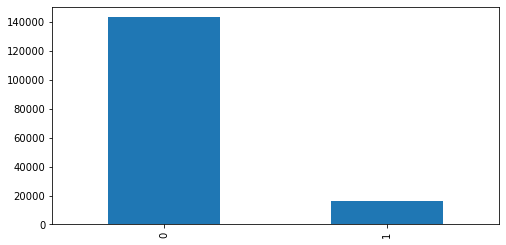

In [7]:
# Проверим дисбаланс
df[TARGET_NAME].value_counts().plot(kind='bar', figsize=(8, 4))

Как видно из графика - присутствует сильный дисбаланс классов, и мы учтем это при обучении модели.

In [8]:
# Посмотрим на параметры текста:
# найдем самый короткий и самый длинный комментарий:
min_size_all = df['text'].str.len().min()
max_size_all = df['text'].str.len().max()
print("самый короткий текст комментария:", min_size_all)
print("самый длинный текст комментария:", max_size_all)

самый короткий текст комментария: 6
самый длинный текст комментария: 5000


In [9]:
# Проверим, что у нас действительно только английский текст, и нет русского:
rus_reg = r'[а-яА-ЯёЁ]'
eng_reg = r'[A-Za-z]'


def find_russian(value):
    return int(re.search(rus_reg, value) is not None)


df['is_rus_text'] = df['text'].apply(find_russian)

print(df['is_rus_text'].unique())
print(df['is_rus_text'].value_counts())

[0 1]
0    159312
1       259
Name: is_rus_text, dtype: int64


In [10]:
df['is_rus_text']

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Name: is_rus_text, Length: 159571, dtype: int64

In [11]:
# Посмотрим на содержание "русских" комментариев:
pd.set_option('display.max_colwidth', -1)
print(df[df['is_rus_text'] == 1]['text'].head(5))

126     Ahh, Hello Witzeman \n\n203.92.84.161  \nSymbols: ~ | ¡ ¿ † ‡ ↔ ↑ ↓ • ¶   # ½ ⅓ ⅔ ¼ ¾ ⅛ ⅜ ⅝ ⅞ ∞   ‘ “ ’ ” «»   ¤ ₳ ฿ ₵ ¢ ₡ ₢ $ ₫ ₯ € ₠ ₣ ƒ ₴ ₭ ₤ ℳ ₥ ₦ № ₧ ₰ £ ៛ ₨ ₪ ৳ ₮ ₩ ¥   ♠ ♣ ♥ ♦   m² m³ \nCharacters: Á á Ć ć É é Í í Ĺ ĺ Ń ń Ó ó Ŕ ŕ Ś ś Ú ú Ý ý Ź ź   À à È è Ì ì Ò ò Ù ù   Â â Ĉ ĉ Ê ê Ĝ ĝ Ĥ ĥ Î î Ĵ ĵ Ô ô Ŝ ŝ Û û Ŵ ŵ Ŷ ŷ   Ä ä Ë ë Ï ï Ö ö Ü ü Ÿ ÿ   ß   Ã ã Ẽ ẽ Ĩ ĩ Ñ ñ Õ õ Ũ ũ Ỹ ỹ   Ç ç Ģ ģ Ķ ķ Ļ ļ Ņ ņ Ŗ ŗ Ş ş Ţ ţ   Đ đ   Ů ů   Ǎ ǎ Č č Ď ď Ě ě Ǐ ǐ Ľ ľ Ň ň Ǒ ǒ Ř ř Š š Ť ť Ǔ ǔ Ž ž   Ā ā Ē ē Ī ī Ō ō Ū ū Ȳ ȳ Ǣ ǣ   ǖ ǘ ǚ ǜ Ă ă Ĕ ĕ Ğ ğ Ĭ ĭ Ŏ ŏ Ŭ ŭ   Ċ ċ Ė ė Ġ ġ İ ı Ż ż   Ą ą Ę ę Į į Ǫ ǫ Ų ų   Ḍ ḍ Ḥ ḥ Ḷ ḷ Ḹ ḹ Ṃ ṃ Ṇ ṇ Ṛ ṛ Ṝ ṝ Ṣ ṣ Ṭ ṭ   Ł ł   Ő ő Ű ű   Ŀ ŀ   Ħ ħ   Ð ð Þ þ   Œ œ   Æ æ Ø ø Å å   Ə ə    \nGreek: Ά ά Έ έ Ή ή Ί ί Ό ό Ύ ύ Ώ ώ   Α α Β β Γ γ Δ δ   Ε ε Ζ ζ Η η Θ θ   Ι ι Κ κ Λ λ Μ μ   Ν ν Ξ ξ Ο ο Π π   Ρ ρ Σ σ ς Τ τ Υ υ   Φ φ Χ χ Ψ ψ Ω ω    \nCyrillic: А а Б б В в Г г   Ґ ґ Ѓ ѓ Д д Ђ ђ   Е е Ё ё Є є Ж ж   З з Ѕ ѕ И и І і   Ї ї Й й Ј ј К к   Ќ ќ Л л Љ љ М м   Н н Њ њ О о П п   Р 

/var/folders/zy/n21wvl254wj5bjdrpk0q3z000000gn/T/ipykernel_1177/423488444.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


#### Промежуточные выводы:   


        В итоге у нас 259 записи-комментарии, в которых присутствуют символы\отдельные слова кирилицы. Большого влияния на нашу работу думаю они не окажут. Оставим их.

    Далее произведем обработку\очистку текста.

In [12]:
def delete_russian(text):
    return re.sub(r'[^A-Za-z]', ' ', text)

df['text'] = df['text'].apply(delete_russian)

In [13]:
# Вернем первоначальные настройки ширины текста и удалим ненужные данные:
pd.set_option('display.max_colwidth', 50)
del df['is_rus_text']

In [14]:
df['text'][3]

'  More I can t make any real suggestions on improvement   I wondered if the section statistics should be later on  or a subsection of   types of accidents     I think the references may need tidying so that they are all in the exact same format ie date format etc  I can do that later on  if no one else does first   if you have any preferences for formatting style on references or want to do it yourself please let me know   There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up  It s listed in the relevant form eg Wikipedia Good article nominations Transport   '

### 1.2. Обработка данных

In [15]:
# Создадим столбец-признак для обработанного текста,
# сразу приведем к нижнему регистру, а также обработаем частые сокращения:
if not USE_PREPARED_CSV:
    df['text_prepared'] = df['text'].str.lower()
    reduction_dict = dict()
    reduction_dict["i'm"] = 'i am'
    reduction_dict["i'd"] = 'i had'
    reduction_dict["i'll"] = 'i will'
    reduction_dict["i've"] = 'i have'
    reduction_dict["you're"] = 'you are'
    reduction_dict["you'd"] = 'you had'
    reduction_dict["you'll"] = 'you will'
    reduction_dict["you've"] = 'you have'
    reduction_dict["he's"] = 'he is'
    reduction_dict["he'd"] = 'he had'
    reduction_dict["he'll"] = 'he will'
    reduction_dict["she's"] = 'she is'
    reduction_dict["she'd"] = 'she had'
    reduction_dict["she'll"] = 'she will'
    reduction_dict["it's"] = 'it is'
    reduction_dict["it'll"] = 'it will'
    reduction_dict["we're"] = 'we are'
    reduction_dict["we'd"] = 'we would'
    reduction_dict["we'll"] = 'we will'
    reduction_dict["we've"] = 'we have'
    reduction_dict["they're"] = 'they are'
    reduction_dict["they'd"] = 'they had'
    reduction_dict["they'll"] = 'they will'
    reduction_dict["they've"] = 'they have'
    reduction_dict["there's"] = 'there is'
    reduction_dict["there'll"] = 'there will'
    reduction_dict["there'd"] = 'there would'
    reduction_dict["isn't"] = 'is not'
    reduction_dict["aren't"] = 'are not'
    reduction_dict["don't"] = 'do not'
    reduction_dict["doesn't"] = 'does not'
    reduction_dict["wasn't"] = 'was not'
    reduction_dict["weren't"] = 'were not'
    reduction_dict["didn't"] = 'did not'
    reduction_dict["haven't"] = 'have not'
    reduction_dict["hasn't"] = 'has not'
    reduction_dict["won't"] = 'will not'
    reduction_dict["hadn't"] = 'had not'
    reduction_dict["can't"] = 'cannot'
    reduction_dict["couldn't"] = 'could not'
    reduction_dict["mustn't"] = 'must not'
    reduction_dict["mightn't"] = 'might not'
    reduction_dict["needn't"] = 'need not'
    reduction_dict["shouldn't"] = 'should not'
    reduction_dict["oughtn't"] = 'ought not'
    reduction_dict["wouldn't"] = 'would not'
    reduction_dict["what's"] = 'what is'
    reduction_dict["how's"] = 'how is'
    reduction_dict["where's"] = 'where is'

    def uncover_reduction(string):
        # Чтобы ускориться, заменим все символы ’ на '
        string_tmp = string.replace('’', "'")

        # Чтобы не перебирать все ключи для каждой строки, для начала отсеим строки, которые вообще не содержат символы сокращений
        if (string_tmp.find("'") == -1):
            return string_tmp

        # Даже если нашли, это могли быть просто слова в кавычках, проверим, что они попадают под сокращения
        parts = ("'s ", "'t ", "'ll ", "'ve ", "'m ", "'d ", "'re ")
        founded = False
        for part in parts:
            if (string_tmp.find(part) != -1):
                founded = True
                break

        # если не нашли сокращения, возвращаем строку как есть (после замены)
        if not founded:
            return string_tmp

        # если нашли сокращения, используем наш словарь и производим замены
        for key, value in reduction_dict.items():
            string_tmp = string_tmp.replace(key, value)

        return string_tmp

    df['text_prepared'] = df['text_prepared'].apply(uncover_reduction)

In [16]:
df.head()

,Unnamed: 0,text,toxic,text_prepared,text_cleared,text_lemmas
0,0,Explanation Why the edits made under my userna...,0,explanation\nwhy the edits made under my usern...,explanation why the edits made under my userna...,explanation edit username hardcore metallica f...
1,1,D aww He matches this background colour I m s...,0,d'aww! he matches this background colour i am ...,daww he matches this background colour i am se...,daww match background colour seemingly stuck t...
2,2,Hey man I m really not trying to edit war It...,0,"hey man, i am really not trying to edit war. i...",hey man i am really not trying to edit war it ...,hey man try edit war guy constantly remove rel...
3,3,More I can t make any real suggestions on im...,0,"""\nmore\ni cannot make any real suggestions on...",more i cannot make any real suggestions on imp...,real suggestion improvement wonder section s...
4,4,You sir are my hero Any chance you remember...,0,"you, sir, are my hero. any chance you remember...",you sir are my hero any chance you remember wh...,sir hero chance remember page s


In [17]:
# Произведем очистку текста. Сохраним результат в отдельной колонке.

if not USE_PREPARED_CSV:
    def clean_text(string):
        string = re.sub(r"[\n\r]", " ", string)
        string = re.sub(r"[^a-zA-Z ]+", "", string)
        return string.strip()

    df['text_cleared'] = df['text_prepared'].apply(clean_text)

df[['text', 'text_cleared']].head()

,text,text_cleared
0,Explanation Why the edits made under my userna...,explanation why the edits made under my userna...
1,D aww He matches this background colour I m s...,daww he matches this background colour i am se...
2,Hey man I m really not trying to edit war It...,hey man i am really not trying to edit war it ...
3,More I can t make any real suggestions on im...,more i cannot make any real suggestions on imp...
4,You sir are my hero Any chance you remember...,you sir are my hero any chance you remember wh...


In [18]:
%%time

# Проведем лемматизацию
if not USE_PREPARED_CSV:
    lookups = Lookups()
    lookups.add_table("lemma_rules", {"noun": [["s", ""]]})
    #lemmatizer = Lemmatizer(lookups)
    nlp = en_core_web_sm.load()

    def lemmatize(string):
        result = []
        for token in nlp(string):
            # тут же очистим стоп-слова
            if token.is_stop == False:
                result.append(token.lemma_)
        return ' '.join(result)

    df['text_lemmas'] = df['text_cleared'].apply(lemmatize)

df[['text', 'text_lemmas']].head()

CPU times: user 10.5 ms, sys: 1.43 ms, total: 11.9 ms
Wall time: 11.2 ms


,text,text_lemmas
0,Explanation Why the edits made under my userna...,explanation edit username hardcore metallica f...
1,D aww He matches this background colour I m s...,daww match background colour seemingly stuck t...
2,Hey man I m really not trying to edit war It...,hey man try edit war guy constantly remove rel...
3,More I can t make any real suggestions on im...,real suggestion improvement wonder section s...
4,You sir are my hero Any chance you remember...,sir hero chance remember page s


In [19]:
df.head()

,Unnamed: 0,text,toxic,text_prepared,text_cleared,text_lemmas
0,0,Explanation Why the edits made under my userna...,0,explanation\nwhy the edits made under my usern...,explanation why the edits made under my userna...,explanation edit username hardcore metallica f...
1,1,D aww He matches this background colour I m s...,0,d'aww! he matches this background colour i am ...,daww he matches this background colour i am se...,daww match background colour seemingly stuck t...
2,2,Hey man I m really not trying to edit war It...,0,"hey man, i am really not trying to edit war. i...",hey man i am really not trying to edit war it ...,hey man try edit war guy constantly remove rel...
3,3,More I can t make any real suggestions on im...,0,"""\nmore\ni cannot make any real suggestions on...",more i cannot make any real suggestions on imp...,real suggestion improvement wonder section s...
4,4,You sir are my hero Any chance you remember...,0,"you, sir, are my hero. any chance you remember...",you sir are my hero any chance you remember wh...,sir hero chance remember page s


In [20]:
# Сохраним обработанный датасет для дальнейшей работы, чтобы не делать лемматизацию повторно.
df.to_csv(PREPARED_CSV)

### 2. Обучение моделей

<div class="alert alert-block alert-warning">
<b>Комментарий студента: </b>  Переделал с учетом обучения моделей на:  
    
    1. дефолтных данных  
    
    2. downsampling данных по классам таргета  
    
    3. balanced данных  
    
</div>

In [21]:
# 1. Подготовим дефолтные признаки:

#data = df[['text_lemmas','toxic']].copy()

df = df.dropna()

train, test = train_test_split(
    df, test_size=0.1, shuffle=True, random_state=RANDOM_STATE)

features_train = train['text_lemmas']
target_train = train['toxic']
features_test = test['text_lemmas']
target_test = test['toxic']

features_train.shape, features_test.shape

((143518,), (15947,))

In [22]:
# 1. в дефолте будем обучать модель с дисбалансом классов:
train['toxic'].value_counts()

0    128926
1     14592
Name: toxic, dtype: int64

In [23]:
# Вариант 2. Подготовим признаки:  проведем  downsampling для учета дисбаланса классов для train:
train_toxic = train[train['toxic'] == 1]
train_nontoxic = train[train['toxic'] == 0]

train_downsampled = pd.concat(
    [train_toxic] + [train_nontoxic.sample(n=len(train_toxic), random_state=RANDOM_STATE)])
train_downsampled['toxic'].value_counts()

1    14592
0    14592
Name: toxic, dtype: int64

In [24]:
features_train_dw = train_downsampled['text_lemmas']
target_train_dw = train_downsampled['toxic']

In [25]:
# рассчитаем Tf-idf
# вариант данных №1 для дефолтной модели и disbalanced:

count_tf_idf = TfidfVectorizer(stop_words=STOP_WORDS) 
count_tf_idf.fit(features_train) 
tf_idf = count_tf_idf.transform(features_train)
print(tf_idf.shape)
print(tf_idf.toarray())

(143518, 193634)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [26]:
# рассчитаем Tf-idf #2 for ngram_range = (2,2)
 
# вариант данных №1 для дефолтной модели и disbalanced:

count_tf_idf2 = TfidfVectorizer(stop_words=STOP_WORDS, ngram_range = (2,2)) 
count_tf_idf2.fit(features_train) 
tf_idf2 = count_tf_idf2.transform(features_train)
print(tf_idf2.shape)
print(tf_idf2.toarray())

(143518, 2051473)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [27]:
# рассчитаем Tf-idf
# вариант данных №2 для  downsampling варианта датасета:

count_tf_idf_dw = TfidfVectorizer(stop_words=STOP_WORDS) 
count_tf_idf_dw.fit(features_train_dw) 
tf_idf_dw = count_tf_idf_dw.transform(features_train_dw)
print(tf_idf_dw.shape)
print(tf_idf_dw.toarray())

(29184, 59554)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
# Определим метрику оценки наших моделей согласно заданию F1:

#f1 = make_scorer(f1_score, average='macro')
f1 = make_scorer(f1_score, average='binary')

### модель LogisticRegression

In [29]:
%%time

# Сделаем поиск лучших гиперпараметров для модели:  

parameters = {'C': (0.1, 0.5, 1.0, 1.5), 
            #  "max_iter":(100,500),
              "fit_intercept": (True, False), 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
grid = GridSearchCV(model, parameters, cv=3, scoring=f1)
grid.fit(tf_idf, target_train)

grid.best_params_

# Для отладки - {'C': 1.0, 'fit_intercept': True, 'solver': 'saga'}

/Users/paulmatus/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paulmatus/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paulmatus/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paulmatus/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

CPU times: user 8min 3s, sys: 1min 34s, total: 9min 38s
Wall time: 4min 16s


{'C': 1.5, 'fit_intercept': True, 'solver': 'newton-cg'}

In [30]:
# 1. построим для начала модель на дефолтных настройках (без учета дисбаланса классов):
model_lr0 = LogisticRegression(random_state=RANDOM_STATE,
                               #class_weight='balanced',
                              fit_intercept=True, C=1.5, solver='saga')

model_lr0.fit(tf_idf, target_train)

tf_idf_test = count_tf_idf.transform(features_test)
predicted_lr = model_lr0.predict(tf_idf_test)

f1_score(target_test, predicted_lr)

0.7647476901208244

In [31]:
# 1.2. Ngrams =2.2, построим для начала модель на дефолтных настройках (без учета дисбаланса классов):
model_lr02 = LogisticRegression(random_state=RANDOM_STATE,
                               #class_weight='balanced',
                              fit_intercept=True, C=1.5, solver='saga')

model_lr02.fit(tf_idf2, target_train)

tf_idf_test2 = count_tf_idf2.transform(features_test)
predicted_lr02 = model_lr02.predict(tf_idf_test2)

f1_score(target_test, predicted_lr02)

0.2551834130781499

In [32]:
# 2. модель на дефолтных настройках + игра балансом классов (class_weight='balanced') 
model_lr = LogisticRegression(random_state=RANDOM_STATE,
                           class_weight='balanced',
                              fit_intercept=True, C=1.5, solver='saga')

model_lr.fit(tf_idf, target_train)

predicted_lr = model_lr.predict(tf_idf_test)

f1_score(target_test, predicted_lr)

/Users/paulmatus/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7559572719802795

In [33]:
# 3. игра балансом классов вручную (class_weight={1: 1.5}) улучшило результат почти на 1.6%
model_lr2 = LogisticRegression(random_state=RANDOM_STATE, 
                               class_weight={1: 1.5},
                               fit_intercept=True, C=1.5, solver='saga')


model_lr2.fit(tf_idf, target_train)

predicted_lr2 = model_lr2.predict(tf_idf_test)

f1_score(target_test, predicted_lr2)

0.780223501523874

In [34]:
# выведем confusion_matrix:  
print(confusion_matrix(target_test, predicted_lr2))
print(classification_report(target_test, predicted_lr2))
print(accuracy_score(target_test, predicted_lr2))

[[14146   169]
 [  480  1152]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14315
           1       0.87      0.71      0.78      1632

    accuracy                           0.96     15947
   macro avg       0.92      0.85      0.88     15947
weighted avg       0.96      0.96      0.96     15947

0.9593026901611589


In [35]:
# 4. Проверим результат на данных с downsampling признаков по классам:
model_lr3 = LogisticRegression(random_state=RANDOM_STATE,
                               # class_weight='balanced',
                               fit_intercept=True, C=1.5, solver='saga')

model_lr3.fit(tf_idf_dw, target_train_dw)
tf_idf_test_dw = count_tf_idf_dw.transform(features_test)
predicted_lr_dw = model_lr3.predict(tf_idf_test_dw)
f1_score(target_test, predicted_lr_dw)

0.6827852998065764

In [36]:
# выведем confusion_matrix:  
print(confusion_matrix(target_test, predicted_lr_dw))
print(classification_report(target_test, predicted_lr_dw))
print(accuracy_score(target_test, predicted_lr_dw))

[[13223  1092]
 [  220  1412]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     14315
           1       0.56      0.87      0.68      1632

    accuracy                           0.92     15947
   macro avg       0.77      0.89      0.82     15947
weighted avg       0.94      0.92      0.93     15947

0.9177274722518342


#### NEW!!!! Промежуточные выводы:
    Мы попробовали 4 разных варианта построения модели LogisticRegression с учетом дисбаланса классов.
    Лучше всего результат (f1=0.78) показала модель на дефолтных данных (disbalanced) + вариант ручной настройки классов class_weight={1: 1.5} и мы даже уложились в требования ТЗ проекта.
    хуже всего показала себя вариант предобработки данных через downsampling (f1=0.68). Странно. Т.к. на других моделях именно модели обученные на downsampling данных показали лучшие результаты. 
    

### модель RandomForestClassifier

In [37]:
# модель с дефолтными данными +  (class_weight='balanced')
classifier = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE,
                                    class_weight='balanced',
                                    #class_weight={1:3},
                                   max_depth=9)
classifier.fit(tf_idf, target_train) 
predicted_rf = classifier.predict(tf_idf_test)
f1_score(target_test, predicted_rf)

0.3643714466203411

In [38]:
# 2. Проверим результат downsampling признаков по классам: тут результат выше, чем по дефолту!
# однако не достаточно высокий, чтобы удовлетворять требованиям ТЗ проекта.
classifier = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE,
                                    #class_weight='balanced',
                                    n_jobs = 1,
                                    #max_samples = 20000,
                                    #class_weight={1:3},
                                   max_depth=9)
classifier.fit(tf_idf_dw, target_train_dw) 
predicted_rf = classifier.predict(tf_idf_test_dw)
f1_score(target_test, predicted_rf)

0.40598531902879725

In [39]:
print(confusion_matrix(target_test, predicted_rf))
print(classification_report(target_test, predicted_rf))
print(accuracy_score(target_test, predicted_rf))

[[10301  4014]
 [  194  1438]]
              precision    recall  f1-score   support

           0       0.98      0.72      0.83     14315
           1       0.26      0.88      0.41      1632

    accuracy                           0.74     15947
   macro avg       0.62      0.80      0.62     15947
weighted avg       0.91      0.74      0.79     15947

0.7361259171003951


RandomForestClassifier выдал наихудшие результаты и явно не умеет работать с подобными задачами. Печаль.

### модель SVC

In [ ]:
parameters = {'C': (0.1, 0.5, 0.7, 1.0), 'kernel': ('linear', 'poly', 'rbf')}
model_svc = SVC(random_state=RANDOM_STATE, class_weight='balanced')
grid = GridSearchCV(model_svc, parameters, cv=3, scoring=f1)
grid.fit(tf_idf, target_train)

grid.best_params_

# Итог - {'C': 1.0, 'kernel': 'linear'}

1.SVC. обучим модель с дефолтными данными +  (class_weight='balanced'):
- почему то на этих данных ноутбук крашится (может не хватает ОЗУ?)

In [ ]:
%%time
# Обучим модель
model_svc = SVC(random_state=RANDOM_STATE, class_weight='balanced',
                C=1.0, kernel='linear', gamma='auto')
model_svc.fit(tf_idf, target_train)

tf_idf_test = count_tf_idf.transform(features_test)
# Посмотрим, что получилось.
predicted_svc = model_svc.predict(tf_idf_test)
f1_score(target_test, predicted_svc)

In [ ]:
# Посмотрим, что получилось.
predicted_svc = model_svc.predict(tf_idf_test)
f1_score(target_test, predicted_svc)

2. SVC. Проверим результат модели на данных downsampling признаков по классам: 

In [ ]:
%%time
# Обучим модель
model_svc2 = SVC(random_state=RANDOM_STATE, class_weight='balanced',
                C=1.0, kernel='linear', gamma='auto')
model_svc2.fit(tf_idf_dw, target_train_dw)
# Посмотрим, что получилось.
predicted_svc2 = model_svc2.predict(tf_idf_test_dw)
f1_score(target_test, predicted_svc2)

In [ ]:
print(classification_report(target_test, predicted_svc2))
print(accuracy_score(target_test, predicted_svc2))

### модель CatBoostClassifier

1.CatBoostClassifier. обучим модель с дефолтными данными +  (class_weight='balanced'):

In [ ]:
train_pool = Pool(
    tf_idf, target_train, 
    #cat_features=cat_features, 
    #text_features=text_features, 
    #feature_names=list(tf_idf)
)
    
valid_pool = Pool(
    tf_idf_test, 
    target_test,
    #cat_features=cat_features, 
    #text_features=text_features, 
    #feature_names=list(tf_idf_test)
)

catboost_params = {
    'iterations': 3000,
    'learning_rate': 0.01,
    'eval_metric': 'F1',
    'task_type': 'CPU',
    'early_stopping_rounds': 300,
    'use_best_model': True,
    'verbose': 500}
    
clas_weight = [5,4]
model_cat = CatBoostClassifier(**catboost_params,class_weights=clas_weight)
model_cat.fit(train_pool, eval_set=valid_pool)


In [ ]:
pred_cat = model_cat.predict(tf_idf_test)
f1_score(target_test, pred_cat)

2. CatBoostClassifier. Проверим результат модели на данных downsampling признаков по классам: 

In [ ]:
train_pool = Pool(
    tf_idf_dw, target_train_dw, 
    #cat_features=cat_features, 
    #text_features=text_features, 
    #feature_names=list(tf_idf)
)
    
valid_pool = Pool(
    tf_idf_test_dw, 
    target_test,
    #cat_features=cat_features, 
    #text_features=text_features, 
    #feature_names=list(tf_idf_test)
)

catboost_params = {
    'iterations': 3000,
    'learning_rate': 0.01,
    'eval_metric': 'F1',
    'task_type': 'CPU',
    'early_stopping_rounds': 300,
    'use_best_model': True,
    'verbose': 500}
    
clas_weight = [5,4]
model_cat = CatBoostClassifier(**catboost_params,class_weights=clas_weight)
model_cat.fit(train_pool, eval_set=valid_pool)

In [ ]:
pred_cat = model_cat.predict(tf_idf_test_dw)
print(classification_report(target_test, pred_cat))
print(accuracy_score(target_test, pred_cat))

In [ ]:
f1_score(target_test, pred_cat)

### Константная модель 

1.Constant-model. обучим модель с дефолтными данными

In [ ]:
# Проверим модель на адекватность на константной модели: f1 = 0.18
# наши модели показывают суущественно лучший результат, и значит наш проект имел смысл!
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(tf_idf, target_train)
predicted = dummy_clf.predict(tf_idf_test)
f1_score(target_test, predicted)

2.Constant-model. обучим модель на данных downsampling признаков по классам: 

In [ ]:
# Проверим модель на адекватность на константной модели: f1 = 0.18
# наши модели показывают суущественно лучший результат, и значит наш проект имел смысл!
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(tf_idf_dw, target_train_dw)
predicted = dummy_clf.predict(tf_idf_test_dw)
f1_score(target_test, predicted)

Проверили модель на адекватность на константной модели: f1 = 0.18.  

Наши модели показывают суущественно лучший результат (f1 = 0.78), и значит наш проект имел смысл!

### Общие выводы

Мы провели анализ и обработку текстовых данных, подготовили их для двльнейшего использования в модели.  

Создали несколько вариантов модели классификации.  

В целом не каждая их них справилась с поставленной задачей преодолеть порог метрики в f1 = 0.75, однако все модели показали результат лучше, чем константная модель.  

Однако в качестве рабочей модели мы бы предложили CatBoostClassifier или LogisticRegression, как показывающие наилучший результат (0.78)  



<div class="alert alert-block alert-warning">
<b>Комментарий студента</b>  Спасибо за полезные ссылки и доп информацию.
</div>